In [1]:
# =======================================
# DeepRacer Simple Log Visualization
# =======================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import os.path
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [3]:
# --- Load CSV and track .npy file---
# replace main_dir with github repo directory
main_dir = "/Users/johannmai/Desktop/Nga/42Horsepower"
track_dir = "tracks"
eval_log_dir = os.path.join(main_dir, "eval_log/")
training_log_dir = os.path.join(main_dir, "training_log/")
#data from csv
df = pd.read_csv(os.path.join(training_log_dir, "test2/sim-trace/training/training-simtrace/8-iteration.csv"))

#track waypoints
track_file = os.path.join(main_dir, track_dir, "2024_reinvent_champ_ccw.npy")
##Parameters
#----------
#waypoints : np.ndarray
#	Array of waypoints with shape (N, 6) → [x_center, y_center, x_left, y_left, x_right, y_right]
waypoints = np.load(track_file, allow_pickle=True)

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)

df["speed"] = df["throttle"]  # If throttle directly maps to speed (adjust if you have actual m/s)
# If throttle is gear-like instead of real m/s, you might need: df["speed"] = df["throttle"] * speed_scale
df["episode"] = df["episode"].astype(int)
#print("Is loop/ring? ", l_center_line.is_ring)

In [4]:
# --- Compute 80% inner race width, prepare for the ideal race line ---
def x_perc_width(waypoint, perc_width):
    
    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint
    
    def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5
    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)
    
    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y
    
    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)
    
    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]

PERC_WIDTH = 0.8
waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)

# Convert to Shapely objects
inner_border_new = waypoints_new[:,2:4]
outer_border_new = waypoints_new[:,4:6]
l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)

In [7]:
## Function to calculate the ideal race line
import copy

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=1000

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, l_inner_border_new, l_outer_border_new)
    if i % 20 == 0: print(".", end = '')
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
ideal_race_line = np.append(race_line, [race_line[0]], axis=0)

/var/folders/4w/bnnqyjz102v7njfpr32s_2580000gn/T/ipykernel_1899/1248994106.py:20: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))


..................................................

In [83]:
def plot_track_angles(center_line, step=5):
	"""
	Plot the track and annotate each waypoint with the direction angle in degrees.

	step : int, optional
		Interval for showing labels (default=5).
	"""
	N = len(center_line)
	xs, ys = center_line[:, 0], center_line[:, 1]

	# Compute direction vectors between consecutive points
	directions = np.roll(center_line, -1, axis=0) - center_line
	directions[N - 1] = directions[0]
	# directions = directions[:N - 1]
	# Compute angles in degrees (-180 to 180)
	angles = np.degrees(np.arctan2(directions[:, 1], directions[:, 0]))
	angles = (angles + 180) % 360 -180 
	plt.figure(figsize=(12, 6))
	plt.plot(xs, ys, "w-", linewidth=1, label="Track center")
	plt.scatter(xs[0], ys[0])
	# Annotate with angles
	for i in range(0, len(angles), step):
		plt.text(xs[i], ys[i], f"{angles[i]:.1f}°", fontsize=7, color="red")

	plt.gca().set_aspect("equal")
	plt.title("Track Direction Angles compare to x-axis")
	plt.legend()
	plt.show()
	return angles

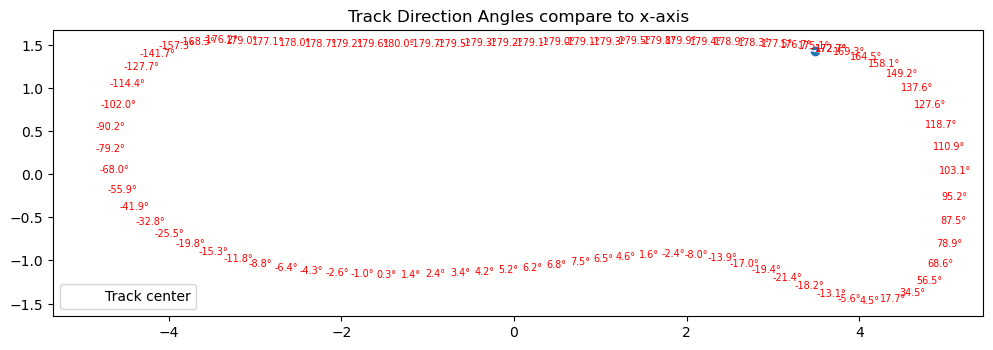

In [84]:
ideal_track_angles = plot_track_angles(ideal_race_line, step=1)

In [74]:
ideal_track_angles

array([ 172.72609401,  175.10539963,  176.6559098 ,  177.50990679,
        178.2601844 ,  178.9020575 ,  179.42305708,  179.85294087,
       -179.79854094, -179.52213268, -179.30805172, -179.14615209,
       -179.02677633, -179.10715105, -179.2127173 , -179.34827573,
       -179.52090567, -179.73745512,  179.98995782,  179.64833096,
        179.22019941,  178.69786056,  178.02027388,  177.12683376,
        178.97343576, -176.24420912, -168.25081145, -157.27252853,
       -141.74622248, -127.69302807, -114.3574103 , -101.95429833,
        -90.21328202,  -79.23729546,  -68.0071572 ,  -55.88888057,
        -41.88853166,  -32.81513566,  -25.45883392,  -19.82757901,
        -15.34395579,  -11.75225037,   -8.84976854,   -6.38262   ,
         -4.34254672,   -2.57713854,   -1.03902299,    0.2855533 ,
          1.41488422,    2.42764888,    3.35773786,    4.24816037,
          5.17446406,    6.2060832 ,    6.84034529,    7.47555412,
          6.52186066,    4.57938346,    1.64711566,   -2.44414

In [75]:
track_angle_diff = np.roll(ideal_track_angles, -1, axis=0) - ideal_track_angles
track_angle_diff = (track_angle_diff + 180) % 360 - 180
for i in range(len(track_angle_diff)):
	print (float(track_angle_diff[i]))

2.3793056247911295
1.5505101681050917
0.8539969892655392
0.7502776098115476
0.6418730930235483
0.5209995879704934
0.42988378984401265
0.34851818241338606
0.2764082622209685
0.2140809583505643
0.1618996383706417
0.11937575867787587
-0.08037472264004464
-0.1055662550544696
-0.1355584236890479
-0.1726299428659388
-0.21654944423201528
-0.2725870686682583
-0.3416268546976653
-0.4281315507643626
-0.5223388484524492
-0.6775866769574463
-0.8934401264693008
1.8466020021839142
4.78235511961708
7.9933976683445
10.978282924594083
15.52630604549691
14.053194413305334
13.335617768139514
12.403111967496784
11.741016312457589
10.975986560703404
11.230138264051334
12.11827662638808
14.000348905314866
9.073395999986246
7.3563017428531055
5.631254911136807
4.4836232209572415
3.5917054141876577
2.902481835030841
2.4671485437025353
2.0400732706841893
1.7654081852477645
1.5381155497979364
1.3245762915929333
1.1293309147374657
1.0127646663825374
0.9300889728622792
0.890422519120051
0.9263036882310303
1.03161

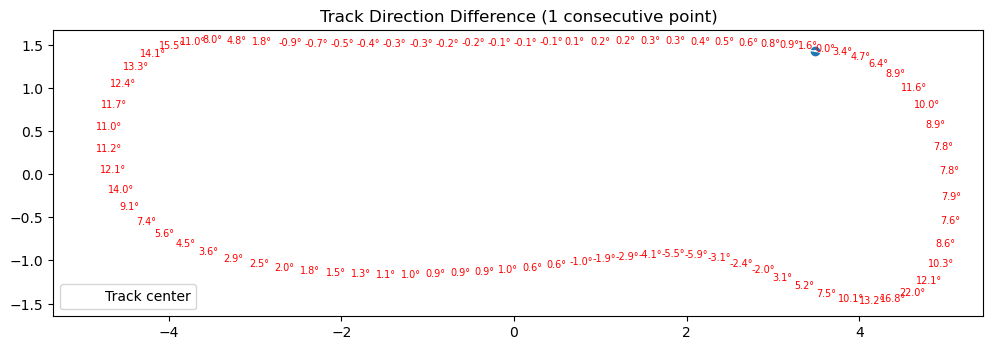

In [79]:
N = len(ideal_race_line) - 1
xs, ys = ideal_race_line[:, 0], ideal_race_line[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(xs, ys, "w-", linewidth=1, label="Track center")
plt.scatter(xs[0], ys[0])
# Annotate with angles
for i in range(1, len(track_angle_diff), 1):
	plt.text(xs[i], ys[i], f"{track_angle_diff[i]:.1f}°", fontsize=7, color="red")

plt.gca().set_aspect("equal")
plt.title("Track Direction Difference (1 consecutive point)")
plt.legend()
plt.show()

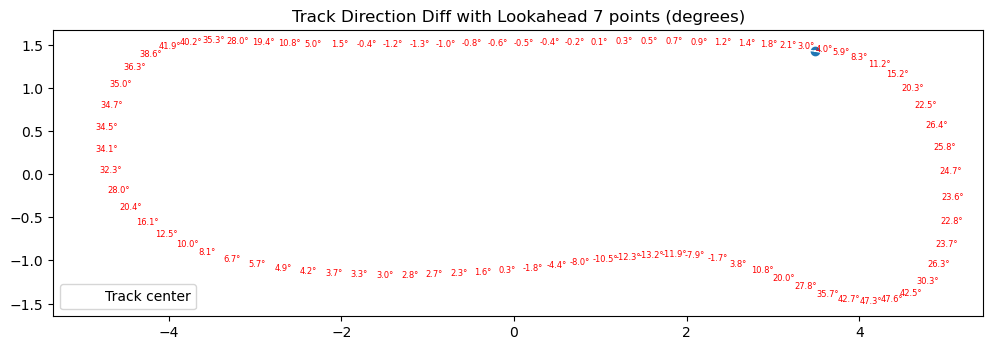

In [78]:
N = len(ideal_race_line)
xs, ys = ideal_race_line[:, 0], ideal_race_line[:, 1]

directions_ahead = []
# Compute direction vectors between consecutive points
for i in range(N):
	x, y = ideal_race_line[i]
	target_idx = (i + 7) % N
	x_ahead, y_ahead = ideal_race_line[target_idx]
	angle_diff = np.degrees(np.arctan2(y_ahead - y, x_ahead - x))
	angle_diff = (angle_diff + 180) % 360 - 180
	directions_ahead.append(angle_diff)
# directions_ahead = directions_ahead[:N - 1]
plot_angle = directions_ahead - ideal_track_angles
plot_angle = (plot_angle + 180) % 360 - 180
# Compute angles in degrees (-180 to 180)
# directions_ahead
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, "w-", linewidth=1, label="Track center")
plt.scatter(xs[0], ys[0])
# Annotate with angles
for i in range(1, len(plot_angle), 1):
	plt.text(xs[i], ys[i], f"{plot_angle[i]:.1f}°", fontsize=6, color="red")

plt.gca().set_aspect("equal")
plt.title("Track Direction Diff with Lookahead 7 points (degrees)")
plt.legend()
plt.show()

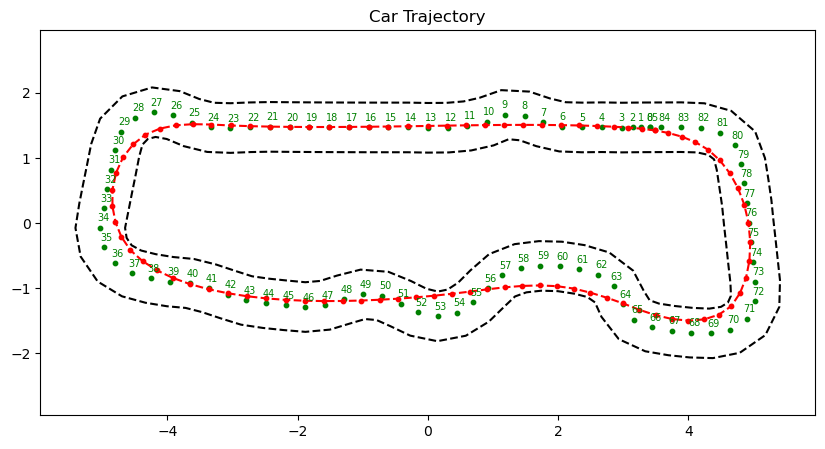

In [19]:
# Visualize a DeepRacer track from an .npy file.
def plot_track(center_line, inner_border, outer_border, show_wp_index=False, show_center_line=False):
	xs, ys = center_line[:, 0], center_line[:, 1]
	left_line = inner_border
	right_line = outer_border

	# Plot
	fig, ax = plt.subplots(figsize=(10, 5))

	ax.plot(left_line[:, 0], left_line[:, 1], 'k--', label="Left Border")
	ax.plot(right_line[:, 0], right_line[:, 1], 'k--', label="Right Border")
	if show_wp_index == True:
		for i in range(0, len(center_line)):
			plt.text(xs[i] - 0.05, ys[i] + 0.1, f"{i}", fontsize=7, color="green")
	if show_center_line == True:
		ax.scatter(xs, ys, s=10, c="green", label="Waypoints")
	ax.axis("equal")
	return fig, ax
# --- 1. Plot Waypoints / Ideal Race Line ---
fig, ax = plot_track(center_line, inner_border, outer_border, True, True)
ax.scatter(ideal_race_line[:, 0], ideal_race_line[:, 1], s=10, c="red", label="ideal")
ax.plot(ideal_race_line[:, 0], ideal_race_line[:, 1], 'r--', label="ideal line")
#ax.plot(df["X"], df["Y"], marker="o", markersize=2, linestyle="-", alpha=0.7)
plt.title("Car Trajectory")
plt.show()

In [90]:
## Calculate maximum velocity on ideal line
g = 9.81

def circle_radius_from_3pts(a, b, c):
    ax, ay = a; bx, by = b; cx, cy = c
    A = bx - ax; B = by - ay; C = cx - ax; D = cy - ay
    E = A*(ax+bx) + B*(ay+by); F = C*(ax+cx) + D*(ay+cy)
    G = 2*(A*(cy-by) - B*(cx-bx))
    if abs(G) < 1e-9:  # nearly collinear -> huge radius
        return 1e9
    cx0 = (D*E - B*F) / G; cy0 = (A*F - C*E) / G
    return math.hypot(ax - cx0, ay - cy0)

def compute_speed_profile(ideal_line_xy, mu=0.6, sf=0.85, vmax=4.0,
                          a_acc=3.0, a_brake=5.0):
	"""
	ideal_line_xy : (N,2) array of x,y points (closed loop)
	returns v_profile (N,)
	"""
	P = np.asarray(ideal_line_xy)
	N = len(P)
	# arc-length spacing
	ds = np.linalg.norm(P[(np.arange(N)+1)%N] - P, axis=1)
	ds[N - 1] = ds[0]
	# curvature-limited speed
	r = np.empty(N)
	for i in range(N):
		r[i] = circle_radius_from_3pts(P[(i-1)%N], P[i], P[(i+1)%N])
	v_curv = np.sqrt(np.clip(mu*g*r, 0, None)) * sf
	v_target = np.minimum(v_curv, vmax)

	# forward pass (accel limit)
	v_fwd = v_target.copy()
	for i in range(N-1):
		v_fwd[i+1] = min(v_fwd[i+1], math.sqrt(max(v_fwd[i]**2 + 2*a_acc*ds[i], 0)))
	# wrap the last->first once (optional)
	v_fwd[0] = min(v_fwd[0], math.sqrt(max(v_fwd[-1]**2 + 2*a_acc*ds[-1], 0)))

	# backward pass (brake limit)
	v_bwd = v_fwd.copy()
	for i in range(N-1, 0, -1):
		v_bwd[i-1] = min(v_bwd[i-1], math.sqrt(max(v_bwd[i]**2 + 2*a_brake*ds[i-1], 0)))
	# wrap first<-last once (optional)
	v_bwd[-1] = min(v_bwd[-1], math.sqrt(max(v_bwd[0]**2 + 2*a_brake*ds[-1], 0)))

	# smooth a bit
	k = 5
	kernel = np.ones(2*k+1)/(2*k+1)
	v_smooth = np.convolve(v_bwd, kernel, mode='same')

	return v_smooth

speedy = compute_speed_profile(ideal_race_line)
speedy


array([2.12443298, 2.48806935, 2.85170571, 3.21534207, 3.57897844,
       3.9426148 , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 3.96714409,
       3.89751481, 3.78815042, 3.63667464, 3.45023143, 3.27485188,
       3.10810696, 2.95057983, 2.79775724, 2.64960929, 2.49680872,
       2.36809673, 2.26331573, 2.22876958, 2.26398606, 2.3600099 ,
       2.46950484, 2.5940405 , 2.73178049, 2.88460309, 3.03275103,
       3.1855516 , 3.34711951, 3.52152979, 3.66544033, 3.78169962,
       3.87211899, 3.9380036 , 3.98021286, 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 3.979573  ,
       3.92578216, 3.86150007, 3.81829888, 3.79496955, 3.79051076,
       3.7610148 , 3.69700445, 3.59501919, 3.45320672, 3.28081138,
       3.10581317, 2.9440648 , 2.8288681 , 2.72389211, 2.62783742,
       2.5401675 , 2.47885839, 2.44727705, 2.4470989 , 2.46497

In [91]:
# --- Calculate expexted finish time
time_lap = 0.0
for i in range(len(ideal_race_line) - 1):
	distance = np.linalg.norm(ideal_race_line[i + 1] - ideal_race_line[i])
	time_lap += distance / speedy[i]
print (time_lap)
speedy.shape

7.276428639959905


(86,)

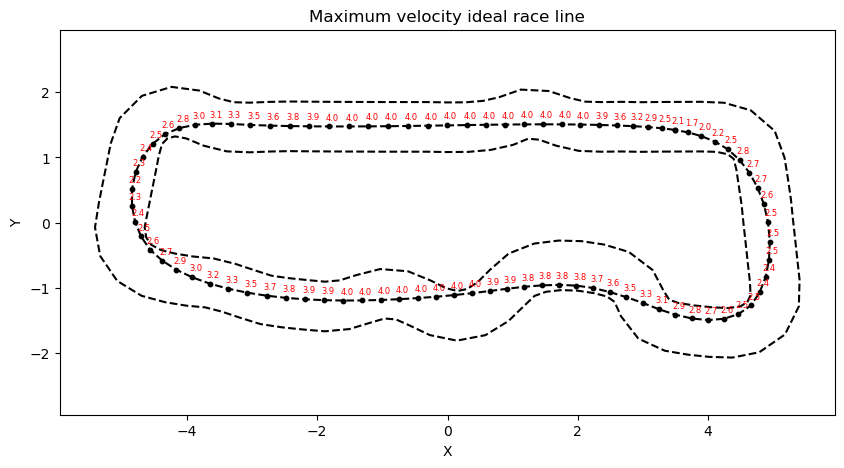

In [100]:
# --- 2. Plot Velocity max ---
fig, ax = plot_track(center_line, inner_border, outer_border)
ax.scatter(ideal_race_line[:, 0], ideal_race_line[:, 1], s=10, c="black", label="ideal")
ax.plot(ideal_race_line[:, 0], ideal_race_line[:, 1], 'k--', label="ideal line")
#ax.plot(df["X"], df["Y"], marker="o", markersize=2, linestyle="-", alpha=0.7)
x = ideal_race_line[:, 0]
y = ideal_race_line[:, 1]
for i in range(0, len(ideal_race_line) - 1, 1):
	plt.text(x[i] - 0.05, y[i] + 0.1, f"{speedy[i]:.1f}", fontsize=6, color="red")
plt.title("Maximum velocity ideal race line")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [93]:
# --- Compute ideal steering angle based on ideal race line and max speed

def _circle_radius_signed(a, b, c):
    """
    Signed radius from three points a,b,c (2D).
    Positive curvature for left turns (CCW), negative for right (CW).
    Returns (kappa), not radius, so it can be very small on straights.
    """
    ax, ay = a; bx, by = b; cx, cy = c
    # side vectors
    AB = np.array([bx-ax, by-ay])
    AC = np.array([cx-ax, cy-ay])
    BC = np.array([cx-bx, cy-by])
    # triangle area (signed)
    cross = AB[0]*AC[1] - AB[1]*AC[0]
    area2 = cross  # 2 * area signed
    # side lengths
    a_len = np.linalg.norm(BC)  # opposite A
    b_len = np.linalg.norm(AC)  # opposite B
    c_len = np.linalg.norm(AB)  # opposite C
    denom = a_len * b_len * c_len
    if denom < 1e-12:
        return 0.0  # nearly collinear/duplicate points -> zero curvature
    # curvature magnitude: k = 4*Area / (a*b*c); with signed area2 = 2*Area
    kappa = (2.0 * area2) / denom
    return kappa  # signed

def curvature_from_polyline(XY):
    """
    Compute signed curvature kappa[i] along a closed polyline XY (N,2).
    Uses a 3-point stencil with circular wrap-around.
    """
    P = np.asarray(XY)
    N = len(P)
    kappa = np.zeros(N)
    for i in range(N):
        a = P[(i-1) % N]
        b = P[i]
        c = P[(i+1) % N]
        kappa[i] = _circle_radius_signed(a, b, c)
    return kappa

def steering_from_line(XY, wheelbase_m=0.18, vmax=4.0,
                       v_profile=None, Ku=0.0,
                       deg=True, steer_limit_deg=30.0,
                       smooth_window=5):
    """
    Compute appropriate steering angle sequence for an ideal line.

    Args:
        XY: (N,2) ideal racing line (closed loop).
        wheelbase_m: car wheelbase in meters.
        vmax: hard cap for speed (m/s) - used only if v_profile provided and needs clipping.
        v_profile: optional (N,) target speeds; if None, geometric steering only.
        Ku: understeer gradient (rad/(m/s)^2); start with 0.0..0.05 for minis.
        deg: return steering in degrees if True.
        steer_limit_deg: clip output to +/- this value.
        smooth_window: moving-average window for mild smoothing of steering.

    Returns:
        steering: (N,) array (deg or rad).
        kappa:    (N,) signed curvature used.
    """
    kappa = curvature_from_polyline(XY)               # signed curvature (1/m)
    delta_geo = np.arctan(wheelbase_m * kappa)        # geometric steering (rad)

    if v_profile is None:
        delta = delta_geo
    else:
        v = np.asarray(v_profile).copy()
        if len(v) != len(XY):
            raise ValueError("v_profile length must match XY length")
        v = np.minimum(v, vmax)
        # speed-dependent correction for understeer (simple model)
        delta = delta_geo + Ku * (v**2) * kappa

    # optional smoothing (circular moving average)
    if smooth_window and smooth_window > 1:
        w = np.ones(2*smooth_window+1) / (2*smooth_window+1)
        # pad circularly
        pad = smooth_window
        dpad = np.r_[delta[-pad:], delta, delta[:pad]]
        delta = np.convolve(dpad, w, mode='valid')  # length N

    # clip to action-space steering limits
    if deg:
        delta = np.degrees(delta)
        delta = np.clip(delta, -steer_limit_deg, steer_limit_deg)
    else:
        limit = math.radians(steer_limit_deg)
        delta = np.clip(delta, -limit, limit)

    return delta, kappa

In [94]:
steer_deg, kappa = steering_from_line(
    ideal_race_line, wheelbase_m=0.18, vmax=4.0,
    v_profile=speedy,  # or None
    Ku=0.03,              # small understeer correction; tune from logs
    deg=True, steer_limit_deg=30.0, smooth_window=5
)

In [ ]:
# --- 2. Plot Steering angle ---
fig, ax = plot_track(center_line, inner_border, outer_border)
ax.scatter(ideal_race_line[:, 0], ideal_race_line[:, 1], s=10, c="black", label="ideal")
ax.plot(ideal_race_line[:, 0], ideal_race_line[:, 1], 'k--', label="ideal line")
x = ideal_race_line[:, 0]
y = ideal_race_line[:, 1]
for i in range(0, len(ideal_race_line), 1):
	plt.text(x[i] - 0.05, y[i] + 0.1, f"{steer_deg[i]:.1f}", fontsize=7, color="blue")

plt.title("Steering angle on ideal race line")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

TypeError: 'Figure' object is not callable

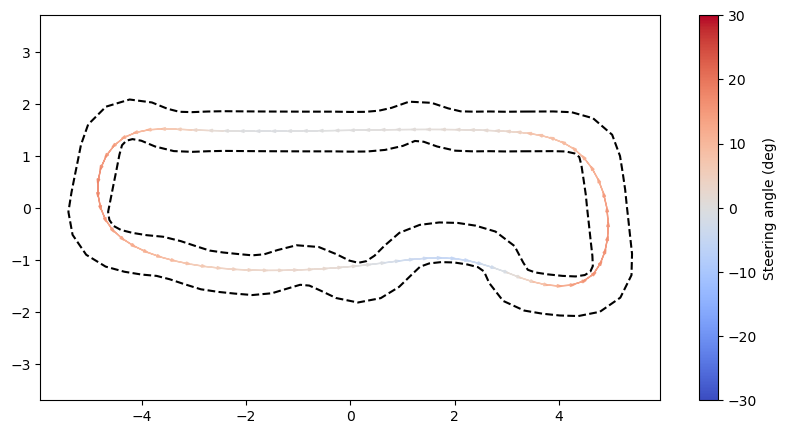

In [34]:
def plot_steering_on_track(ax, XY, steering_deg, scale=0.3, cmap="coolwarm"):
    """
    Overlay steering directions as colored arrows on an existing track plot.

    Args:
        ax          : matplotlib Axes (from plot_track)
        XY          : (N,2) array of ideal racing line points
        steering_deg: (N,) steering angles in degrees
        scale       : arrow length scaling factor
        cmap        : colormap name for steering values
    """
    # Normalize steering for colormap (e.g., -30..30 degrees)
    smin, smax = -30, 30
    norm = plt.Normalize(vmin=smin, vmax=smax)
    cmap = plt.get_cmap(cmap)

     # Compute local tangent directions of track
    directions = np.roll(XY, -1, axis=0) - XY
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    directions = directions / np.maximum(norms, 1e-6)  # avoid div by zero

    for (x, y), (dx, dy), steer in zip(XY, directions, steering_deg):
        color = cmap(norm(steer))
        ax.arrow(x, y, dx*scale, dy*scale,
                 head_width=0.05, head_length=0.08,
                 fc=color, ec=color, alpha=0.9, length_includes_head=True)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Steering angle (deg)")
fig, ax = plot_track(center_line, inner_border, outer_border)
plot_steering_on_track(ax, ideal_race_line, steer_deg, scale=0.3, cmap="coolwarm")
plt.show()

Text(0.5, 1.0, 'trial')

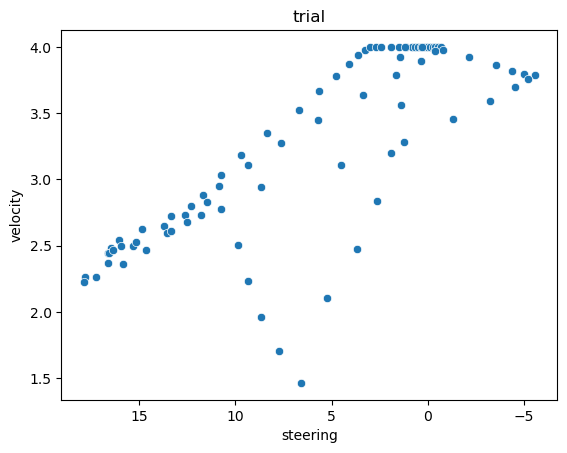

In [ ]:
all_actions = pd.DataFrame({"velocity":speedy,
                            "steering":steer_deg})
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"trial")